In [31]:
# необходимые импорты. если ругается, что какой-то библиотеки нет - pip install 

import numpy as np
import pandas as pd
import hvplot.pandas
import panel as pn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import OrderedDict
import holoviews as hv
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

# sns.set()
# sns.reset_defaults()

In [32]:
PATH = 'data/'  # путь к коталогу с данными (включительно) 

In [33]:
# всякие нужные функции

def get_data(path=PATH):  
    avaliable_files = list(filter(lambda name: '.csv' in name, os.listdir(path)))  
    tasks = pd.read_csv(path + avaliable_files[0], nrows=1).filter(regex='Упражнение \d+:.*').columns.values
    colnames = np.append(np.array(['Student ID', 'Username', 'Grade', 'Grade percent', 'Упражнение (Avg)']), tasks) 
    dates_df = {}
    for filename in avaliable_files:
        date = pd.Timestamp(re.search('depersonalized_(.*).csv', filename).group(1))
        dates_df[date] = pd.read_csv(path + filename, usecols=colnames, index_col=['Student ID', 'Username'])
    return dates_df, tasks

def mpl_plot(s, p, n):
    fig = Figure()
    FigureCanvas(fig) 
    ax = fig.add_subplot()
    bars = ax.bar(range(3), [s, p, n])
    ax.bar_label(bars)
    ax.set_xticks(range(3))
    ax.set_xticklabels(['Справились', 'Частично справились', 'Не справились'])
    ax.tick_params(axis='x', labelrotation = 10)
    ax.set_ylabel('Кол-во человек')
    ax.margins(y=0.1)
    return fig

def plot_everything(date_begin='01.01.2021', date_end='01.01.2023', user_bar='Все', 
                    task_bar='Все', view_fn=mpl_plot):
    current_data = {}
    for date in data.keys():
        if pd.to_datetime(date_begin, dayfirst=True) <= date <= pd.to_datetime(date_end, dayfirst=True):
            current_data[date] = data[date]
    dates = list(current_data.keys())
    if user_bar == 'Все':
        if task_bar == 'Все':
            progress = [value['Grade percent'].mean() for value in current_data.values()]
            output = pd.DataFrame(progress, dates) 
        else:
            taskname = list(filter(lambda name: str(task_bar) in name, colnames))[0]
            progress = [value[taskname].mean() * 100 for value in 
                             current_data.values()]
            output = pd.DataFrame(progress, dates) 
    else:
        if task_bar == 'Все':
            progress = [value.xs(user_bar, level='Username', drop_level=False)['Grade percent'] for value in 
                    current_data.values()]
            output = pd.DataFrame(progress, dates)
        else:
            taskname = list(filter(lambda name: str(task_bar) in name, colnames))[0]
            progress = [value.xs(user_bar, level='Username', drop_level=False)[taskname] for value in 
                    current_data.values()]
            output = pd.DataFrame(progress, dates) 
    return view_fn(output)

def hvplot1(df):
    line = df.hvplot(height=300, width=500, xlabel='Дата', ylabel='Прогресс, %', ylim=(0, 100))
    return line

def get_stats(df, taskname):
    solved = len(df[df[taskname] == 1])
    partially_solved = len(df[(0 < df[taskname]) & (df[taskname] < 1)])
    not_solved = len(df[df[taskname] == 0])
    return solved, partially_solved, not_solved

def success(date='01.01.2022', task='1', view_fn=mpl_plot):
    taskname = list(filter(lambda name: str(task) in name, colnames))[0]
    date = pd.to_datetime(date)
    closest = None
    for key in data.keys():
        if closest is None or closest < key <= date:
            closest = key
    return view_fn(*get_stats(data[closest], taskname))

def overall_stats(date_begin='01.01.2021', date_end='01.01.2023'):
    current_data = {}
    for date in data.keys():
        if pd.to_datetime(date_begin, dayfirst=True) <= date <= pd.to_datetime(date_end, dayfirst=True):
            current_data[date] = data[date]
    tasks = list(filter(lambda col: ': Упражнение' in col, colnames))
    df = current_data[list(current_data.keys())[-1]]
    best = 0
    t = 0
    solved, partially_solved, not_solved = [], [], []
    for i, taskname in enumerate(tasks):
        s, p, n = get_stats(df, taskname)
        if s > best:
            best = s
            t = i+1
        solved.append(s)
        partially_solved.append(p)
        not_solved.append(n)
    fig = Figure()
    FigureCanvas(fig) 
    ax = fig.add_subplot()
    x = np.arange(len(tasks))
    width = 0.35 
    rects1 = ax.bar(x - width/2, solved, width, label='Справились')
    rects2 = ax.bar(x + width/2, not_solved, width, label='Не справились')
    rects3 = ax.bar(x, partially_solved, width, label='Частично справились')
    ax.set_ylabel('Кол-во человек')
    ax.set_title(f'Лучше всего справились с упражнением {t}')
    ax.set_xticks(x)
    ax.set_xticklabels(range(1, len(x)+1))
    ax.set_xlabel('Упражнение')
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    ax.legend(loc='best')
    ax.margins(y=0.3)
    return fig

def do_smth(TOP=10, date_begin='01.01.2021', date_end='01.01.2023'):
    current_data = {}
    for date in data.keys():
        if pd.to_datetime(date_begin, dayfirst=True) <= date <= pd.to_datetime(date_end, dayfirst=True):
            current_data[date] = data[date]
    dates = list(current_data.keys())
    name_gradepercent_begin = current_data[dates[0]]['Grade percent'].droplevel(0)
    name_gradepercent_end = current_data[dates[-1]]['Grade percent'].droplevel(0)
    sorted_progress = name_gradepercent_end.subtract(name_gradepercent_begin, fill_value=0).sort_values(ascending=False)
    sorted_progress = sorted_progress.apply(int)
    top = []
    for user in zip(sorted_progress[:TOP].index, sorted_progress[:TOP].values):
        top.append(f"{user[0]} ({user[1]}%)")
    print(f"Топ {TOP} человек: {', '.join(top)}.")
    fig, ax = plt.subplots(figsize=(15, 4))
    sorted_progress.groupby(sorted_progress).count().plot.bar(title=f"Количество людей, придвинувшихся с {date_begin} по {date_end} на n-ное кол-во процентов",
                                                              ylabel='Кол-во человек', xlabel='Процент, на который люди продвинулись')
    plt.show()

In [34]:
# для интерактивной визуализации

pn.extension()

data, tasknames = get_data()
colnames = list(data.values())[0].columns

kw = dict(date_begin=pn.widgets.TextInput(name='Начальная дата', value='01.01.2021', placeholder='dd.mm.yyyy', max_length=10, width=100), 
          date_end=pn.widgets.TextInput(name='Конечная дата', value='01.01.2023', placeholder='dd.mm.yyyy', max_length=10, width=100),
          user_bar=pn.widgets.TextInput(name='Пользователь', value='Все', placeholder='Введите Username или "Все"', width=220), 
          task_bar=pn.widgets.Select(name='Упражнение', options=np.append(tasknames, ['Все']).tolist(), width=220))
kw2 = dict(date=pn.widgets.TextInput(name='Дата', value='01.01.2021', placeholder='dd.mm.yyyy', max_length=10, width=100),  
           task=pn.widgets.Select(name='Упражнение', options=np.append(tasknames, ['Все']).tolist(), width=220))

kw3 = dict(date_begin=pn.widgets.TextInput(name='Начальная дата', value='01.01.2021', placeholder='dd.mm.yyyy', max_length=10, width=100), 
          date_end=pn.widgets.TextInput(name='Конечная дата', value='01.01.2023', placeholder='dd.mm.yyyy', max_length=10, width=100))

In [35]:
# визуализация прогресса

app1 = pn.interact(plot_everything, view_fn=hvplot1, **kw)
pn.Row(pn.Column("## Прогресс\n", pn.Row(app1[0][0], app1[0][1]), pn.Column(app1[0][2], app1[0][3])), pn.Row(app1[1][0]))

Row
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] TextInput(max_length=10, name='Начальная дата', placeholder='dd.mm.yyyy', value='01.01.2021', width=100)
            [1] TextInput(max_length=10, name='Конечная дата', placeholder='dd.mm.yyyy', value='01.01.2023', width=100)
        [2] Column
            [0] TextInput(name='Пользователь', placeholder='Введите Username и..., value='Все', width=220)
            [1] Select(name='Упражнение', options=['Упражнение 1: Упражнение...], value='Упражнение 1: У..., width=220)
    [1] Row
        [0] HoloViews(Curve, name='interactive00950')

Row
    [0] Column
        [0] Markdown(str)
        [1] TextInput(max_length=10, name='Дата', placeholder='dd.mm.yyyy', value='01.01.2021', width=100)
        [2] Select(name='Упражнение', options=['Упражнение 1: Упражнение...], value='Упражнение 1: У..., width=220)
    [1] Row
        [0] Row
            [0] Matplotlib(Figure, name='interactive01065')
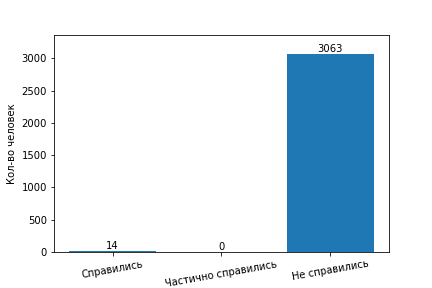

In [36]:
# визуализация того, насколько успешно люди в целом справились с каждым из заданий

app2 = pn.interact(success, view_fn=mpl_plot, **kw2)
pn.Row(pn.Column("## Успешность выполнения\n", app2[0][0], app2[0][1]), pn.Row(app2[1]))

Row
    [0] Column
        [0] Markdown(str)
        [1] TextInput(max_length=10, name='Начальная дата', placeholder='dd.mm.yyyy', value='01.01.2021', width=100)
        [2] TextInput(max_length=10, name='Конечная дата', placeholder='dd.mm.yyyy', value='01.01.2023', width=100)
    [1] Row
        [0] Matplotlib(Figure, name='interactive01079')
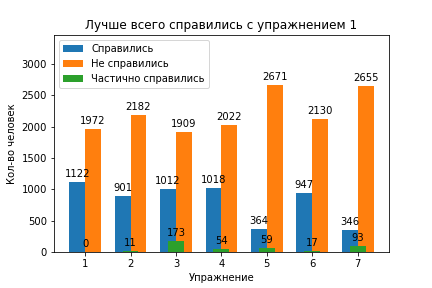

In [37]:
# визуализация того, насколько успешно люди в целом справились в целом

app3 = pn.interact(overall_stats, **kw3)
pn.Row(pn.Column("## Общая статистика\n", app3[0][0], app3[0][1]), app3[1])

In [40]:
# с последним у меня не получилось интерактивно, поэтому что есть, то есть

TOP = 10  # скольких людей из топа необходимо вывести
BEGIN = '01.01.2021'  # начальная дата
END = '01.01.2023'  # конечная дата

Топ 10 человек: User_2390 (100%), User_2396 (100%), User_2389 (100%), User_2388 (100%), User_2381 (100%), User_2379 (100%), User_2378 (100%), User_2371 (100%), User_2370 (100%), User_2369 (100%).


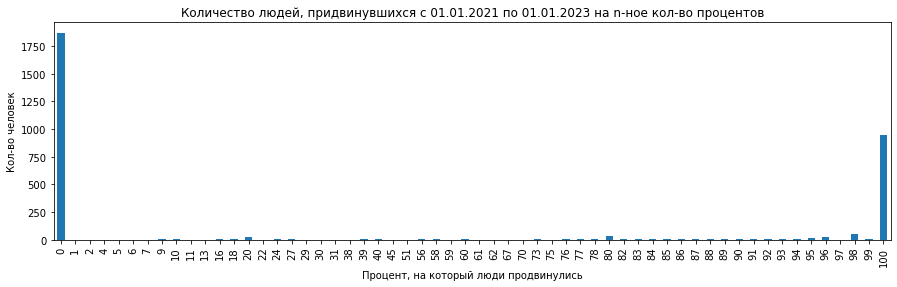

In [41]:
do_smth(TOP, BEGIN, END)